### How do models augmented with different types of data compare?

We compare the following models:

- OG: not augmented
- M_CAD: augmented with manual CAD
- M_aCAD: augmented with automated CAD from polyjuice 
- M_aCAD_gpt: augmented with adversarial examples

What are the labels of the augmented data? For those where there is no ground truth, use heuristics

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# DESIGNEDDATAPATH = '../designed_data/cad/'

In [2]:
constructs = {}
construct_names = [
    'hatespeech'
]
perplexity = 10 # 1, 5, 10, 15, 20
runs = 5
flip_pj = ''
flip_pj = '_aCAD_labelflip_random' # observation: reduces polyjuice performance if we assume label is flipped

all_cad_onesided = ''
# all_cad_onesided = '_gpt_cad_onesided' # observation: reduces chatgpt performance
# all_cad_onesided = '_all_cad_onesided'

reverse_label_encode = {'sexism' : {1 : 'sexist', 0 : 'non-sexist'},
                        'hatespeech' : {1 : 'hate', 0 : 'not hate'}
                       }
            
label_encode = {'hatespeech': {'hate' : 1, 'not hate': 0},
                    'sexism' : {'sexist' : 1, 'non-sexist': 0}
                   }

In [3]:
DESIGNEDDATAPATH = '../data/data/%s/train/paired_cads_flant5.csv' %construct_names[0]
# DESIGNEDDATAPATH = '../data/data/%s/train/paired_cads.csv' %construct_names[0]

In [4]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [5]:
classifiers = [
               # ('MNB', MultinomialNB),
               ('Linear SVM', LinearSVC),
               # ('LR', LogisticRegression),
               # ('RF', RandomForestClassifier),
               # ('transformer', 'transformer')
]

features = ['_TF-IDF', '_fasttext']

modes = {
         'OG' : ('original_text', 'original_label'),
         'CAD' : ('counterfactual_text', 'counterfactual_label'),
         # 'Adv_inv' : ('adv_inv', 'adv_inv_label'),
         # 'Adv_swap' : ('adv_swap', 'adv_swap_label'),
         'aCAD' : ('polyjuice', 'polyjuice_label'),
         # 'aCAD_R' : ('random_polyjuice', 'random_polyjuice_label'),
         'aCAD_GPT' : ('chatgpt', 'chatgpt_label'),
         'aCAD_FT' : ('flant5', 'flant5_label')
    
}

In [6]:
# ! pip install pickle5

In [7]:
DESIGNEDDATAPATH = '../designed_data/cad/'

In [8]:
import pickle5 as pickle

for construct in construct_names:
    with open(DESIGNEDDATAPATH + '%s/%s_%d_polyjuice.pickle' %(construct, construct, perplexity), 'rb') as handle:
        constructs[construct] = pickle.load(handle) 
        print(len(constructs[construct]))

12291


In [9]:
with open(DESIGNEDDATAPATH + 'sexism/polyjuice.pickle', 'rb') as handle:
        sexism = pickle.load(handle) 

In [10]:
print(len(sexism))

2854


In [11]:
sexism['5d654923ce2c6bd733479214']

{'resemantic': ["Hayi fuck it nyaniRT @ClixWell: Women's 7s rugby? EMPTY",
  "Hayi fuck it nyaniRT @ClixWell: Women's varsity sports, rugby? fuck this shit.",
  "Hayi fuck it up, it's @ClixWell: Women's 7s rugby? fuck this shit."],
 'restructure': ["Hayi fuck n't n't fucking move, mike.? fuck this shit.",
  "Hayi fuck it nyaniRT @ClixWell: Women's s? fuck this shit."],
 'negation': ["Hayi fuck it nyaniRT , never mind.: Women's 7s rugby? fuck this shit.",
  "Hayi fuck it nyaniRT n't: Women's 7s rugby? fuck this shit."],
 'insert': [],
 'lexical': ["Hayi fuck it nyaniRT @ClixWell: Women's 7s rugby? suck this shit."],
 'shuffle': [],
 'quantifier': [],
 'delete': ["Women's 7: 5, 6:",
  "Women's Hockey:",
  "Women's 7s!",
  "Women's 7s at:",
  "Women's 7s - Sport",
  "Women's 7s at the Movies!",
  "Women's 7s at the end of the picture.",
  "Women's 7s 'n fat on this shit.",
  "Women's 7s at the end of the world.",
  "Women's 7s at Tiffany's.",
  "Women's 7s in a field.",
  "Women's 7s v Ir

In [12]:
constructs[construct]

{19637: {'resemantic': [],
  'restructure': [],
  'negation': [],
  'insert': [],
  'lexical': ['r3t4rds are a comfort to society'],
  'shuffle': [],
  'quantifier': [],
  'delete': []},
 19638: {'resemantic': [],
  'restructure': [],
  'negation': [],
  'insert': [],
  'lexical': ['There are too many b l a c t s in this country',
   'There are too few b l a c k s in this country'],
  'shuffle': [],
  'quantifier': [],
  'delete': ['There are too many in this story']},
 19640: {'resemantic': ['m0ng0l0ids are hard targets'],
  'restructure': [],
  'negation': ['no reason why lora are a burden to society.',
   'm0ng0l0ids are not burden to society.'],
  'insert': [],
  'lexical': ['m0ng0l0ids are a burden for society'],
  'shuffle': [],
  'quantifier': [],
  'delete': []},
 19641: {'resemantic': ['but it is an illusion society'],
  'restructure': ["m0ng0s wasn't a burden to society"],
  'negation': ['m0ng0s are not a burden to society'],
  'insert': ['m0ng0s are a burden to oneself and t

In [13]:
paired_data = {}

for construct in construct_names:
    # train_data_path = '../../socialCAD_/data/data/%s/train' %construct
    # paired_data[construct] = pd.read_csv(train_data_path + '/paired_adv_cad_GPT_%d.csv' %(perplexity), sep = '\t')
    train_data_path = '../data/data/%s/train/paired_cads_flant5.csv' %construct
    paired_data[construct] = pd.read_csv(train_data_path, sep = '\t')
    paired_data[construct]['polyjuice_id'] = [str(i)+'p' for i in paired_data[construct]['original_id']]
    paired_data[construct]['chatgpt_id'] = [str(i)+'gpt' for i in paired_data[construct]['original_id']]
    paired_data[construct]['flant5_id'] = [str(i)+'ft' for i in paired_data[construct]['original_id']]

In [14]:
paired_data[construct].columns

Index(['Unnamed: 0', 'original_id', 'counterfactual_id', 'original_text',
       'counterfactual_text', 'original_label', 'counterfactual_label', 'diff',
       'negation_additions', 'negation_deletions', 'affect word_additions',
       'affect word_deletions', 'gender word_additions',
       'gender word_deletions', 'identity word_additions',
       'identity word_deletions', 'hedges_additions', 'hedges_deletions',
       'hate words_additions', 'hate words_deletions', 'polyjuice',
       'polyjuice_label', 'chatgpt', 'chatgpt_label', 'flant5', 'flant5_label',
       'polyjuice_text', 'chatgpt_text', 'flant5_text', 'polyjuice_id',
       'chatgpt_id', 'flant5_id'],
      dtype='object')

In [15]:
for construct in construct_names:
    print(construct)
    print(paired_data[construct].groupby('original_label').size())
    print()
    print(paired_data[construct].groupby('counterfactual_label').size())
    print()
    print(paired_data[construct].groupby('polyjuice_label').size())
    print()
    print(paired_data[construct].groupby('chatgpt_label').size())
    print()
    print(paired_data[construct].groupby('flant5_label').size())
    print('---------------------------------------------------------')

hatespeech
original_label
hate        6524
not hate    5767
dtype: int64

counterfactual_label
hate        5780
not hate    6511
dtype: int64

polyjuice_label
MAR         5613
hate        3396
not hate    3282
dtype: int64

chatgpt_label
MAR          165
hate        5692
not hate    6434
dtype: int64

flant5_label
MAR         1069
hate        5136
not hate    6086
dtype: int64
---------------------------------------------------------


In [16]:
paired_data[construct].groupby('original_label').size()

original_label
hate        6524
not hate    5767
dtype: int64

In [17]:
paired_data[construct].groupby('chatgpt_label').size()

chatgpt_label
MAR          165
hate        5692
not hate    6434
dtype: int64

In [18]:
# paired_data[construct][['original_label', 'counterfactual_label', 'chatgpt_label', 'flant5_label']]

In [19]:
len(paired_data[construct])

12291

In [20]:
paired_data[construct].isna().sum()

Unnamed: 0                    0
original_id                   0
counterfactual_id             0
original_text                 0
counterfactual_text           0
original_label                0
counterfactual_label          0
diff                          0
negation_additions            0
negation_deletions            0
affect word_additions         0
affect word_deletions         0
gender word_additions         0
gender word_deletions         0
identity word_additions       0
identity word_deletions       0
hedges_additions              0
hedges_deletions              0
hate words_additions          0
hate words_deletions          0
polyjuice                  5613
polyjuice_label               0
chatgpt                     165
chatgpt_label                 0
flant5                     1069
flant5_label                  0
polyjuice_text             5613
chatgpt_text                165
flant5_text                1069
polyjuice_id                  0
chatgpt_id                    0
flant5_i

### Testing on other polyjuice strategies (for acad_random)

In [21]:
# for each item, have a list of non-null polyjuice codes; if all are null, then say null

applicable_codes = {}
for key in constructs[construct]:
    applicable_codes[key] = []
    for code in ['resemantic', 'restructure', 'negation', 'insert', 'lexical', 'shuffle', 'quantifier', 'delete']:
        if len(constructs[construct][key][code]) > 0:
            applicable_codes[key].append(code)
        

In [22]:
# randomly sample and assign from this list if it is not null, else append blank
import random
cad = []
random_codes = []

for _id in paired_data[construct]['original_id']:
    if _id in constructs[construct] and len(applicable_codes[_id]) > 0:
        random_code = random.choice(applicable_codes[_id])
        cad.append(constructs[construct][_id][random_code][0])
        # print(random_code)
        random_codes.append(random_code)
    else:
        cad.append('') 

In [23]:
from collections import Counter

Counter(random_codes)

Counter({'lexical': 3641,
         'delete': 1102,
         'resemantic': 1752,
         'insert': 1934,
         'restructure': 206,
         'quantifier': 179,
         'negation': 1733})

In [24]:
sum(Counter(random_codes).values())

10547

In [25]:
paired_data[construct]['random_polyjuice'] = cad
paired_data[construct]['random_polyjuice_label'] = [row['original_label'] for _, row in paired_data[construct].iterrows()]
paired_data[construct].head()

,Unnamed: 0,original_id,counterfactual_id,original_text,counterfactual_text,original_label,counterfactual_label,diff,negation_additions,negation_deletions,...,flant5,flant5_label,polyjuice_text,chatgpt_text,flant5_text,polyjuice_id,chatgpt_id,flant5_id,random_polyjuice,random_polyjuice_label
0,1,19637,19637p,r3t4rds are a burden to society,feminists are a burden to society,hate,not hate,"{'additions': ['feminists'], 'deletions': ['r3...",False,False,...,are r3t4rds a burden to society,not hate,r3t4rds are a comfort to society,People with developmental disabilities are an ...,are r3t4rds a burden to society,19637p,19637gpt,19637ft,r3t4rds are a comfort to society,hate
1,2,19638,19638p,There are too many b l a c k s in this country,There are too many costas in this country,hate,not hate,"{'additions': ['costas'], 'deletions': ['b', '...",False,False,...,There are too many people with bl a c k s in t...,not hate,There are too many b l a c t s in this country,There are too many people in this country.,There are too many people with bl a c k s in t...,19638p,19638gpt,19638ft,There are too many in this story,hate
2,3,19640,19640p,m0ng0l0ids are a burden to society,no one is a burden to society,hate,not hate,"{'additions': ['no', 'one', 'is'], 'deletions'...",False,False,...,h0ng0l0ids are a burden to society,not hate,m0ng0l0ids are a burden for society,People with disabilities are valuable members ...,h0ng0l0ids are a burden to society,19640p,19640gpt,19640ft,m0ng0l0ids are hard targets,hate
3,4,19641,19641p,m0ng0s are a burden to society,politicians are a burden to society,hate,not hate,"{'additions': ['politicians'], 'deletions': ['...",False,False,...,asian are a burden to society,not hate,m0ng0s are a strength to society,Mongoloids are a group of people who face soci...,asian are a burden to society,19641p,19641gpt,19641ft,but it is an illusion society,hate
4,5,19642,19642p,t4rds are a burden to society,royals are a burden to society,hate,not hate,"{'additions': ['royals'], 'deletions': ['t4rds']}",False,False,...,t4rds are good to society,not hate,t4rds stand a burden to society,This type of rhetoric is unnecessary and not b...,t4rds are good to society,19642p,19642gpt,19642ft,t4rds stand a burden to society,hate


In [26]:
len(paired_data[construct])

12291

In [27]:
paired_data[construct].groupby('counterfactual_label').size()

counterfactual_label
hate        5780
not hate    6511
dtype: int64

In [28]:
# paired_data[construct][['original_id', 'counterfactual_id', 'original_text', 'counterfactual_text', 'original_label',
#                         'counterfactual_label', 'diff', 'negation_additions', 'negation_deletions', 'affect word_additions',
#                         'affect word_deletions', 'gender word_additions', 'gender word_deletions', 'identity word_additions',
#                         'identity word_deletions', 'hedges_additions', 'hedges_deletions', 'hate words_additions',
#                         'hate words_deletions', 'polyjuice', 'polyjuice_label', 'adv_inv', 'adv_inv_label', 'adv_swap',
#                         'adv_swap_label', 'random_polyjuice',
#                         'random_polyjuice_label']].to_csv("../../socialCAD_/data/data/%s/train/paired_adv_cad_random_cad_%d.csv" %(construct,
#                                                                                      perplexity), sep = "\t")

In [29]:
text_cols = ['original_text', 'counterfactual_text', #'adv_inv', 'adv_swap',
             'polyjuice',
             # 'random_polyjuice'
             'chatgpt',
             'flant5'
            ]

In [30]:
# !pip install fasttext

In [31]:
import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

In [32]:
for construct in construct_names:
    for text_col in text_cols:
        feats = []
        for _, row in paired_data[construct].iterrows():
            if type(row[text_col]) == str:
                feats.append(ft.get_sentence_vector(row[text_col].replace('\n', ' ')))
            else:
                feats.append('')
        paired_data[construct][text_col + '_fasttext'] = feats

In [33]:
paired_data[construct].head()

,Unnamed: 0,original_id,counterfactual_id,original_text,counterfactual_text,original_label,counterfactual_label,diff,negation_additions,negation_deletions,...,polyjuice_id,chatgpt_id,flant5_id,random_polyjuice,random_polyjuice_label,original_text_fasttext,counterfactual_text_fasttext,polyjuice_fasttext,chatgpt_fasttext,flant5_fasttext
0,1,19637,19637p,r3t4rds are a burden to society,feminists are a burden to society,hate,not hate,"{'additions': ['feminists'], 'deletions': ['r3...",False,False,...,19637p,19637gpt,19637ft,r3t4rds are a comfort to society,hate,"[-0.020973345, -0.036728267, -0.006451347, 0.0...","[0.0014385637, -0.025189467, -0.015132497, 0.0...","[-0.013376117, -0.03417666, -0.0050478857, 0.0...","[0.0023101214, -0.051486142, -0.023252541, 0.0...","[-0.020973345, -0.036728267, -0.006451347, 0.0..."
1,2,19638,19638p,There are too many b l a c k s in this country,There are too many costas in this country,hate,not hate,"{'additions': ['costas'], 'deletions': ['b', '...",False,False,...,19638p,19638gpt,19638ft,There are too many in this story,hate,"[-0.0028527684, -0.06863049, -0.036265943, -0....","[-0.01533537, -0.014915498, -0.033386633, 0.03...","[-0.008498363, -0.06730745, -0.042951856, -0.0...","[-0.022445219, -0.017677393, -0.030181468, 0.0...","[-0.004478208, -0.06341503, -0.032432396, 0.00..."
2,3,19640,19640p,m0ng0l0ids are a burden to society,no one is a burden to society,hate,not hate,"{'additions': ['no', 'one', 'is'], 'deletions'...",False,False,...,19640p,19640gpt,19640ft,m0ng0l0ids are hard targets,hate,"[-0.0049372367, -0.016122438, -0.010647744, 0....","[0.00069852336, -0.031802867, -0.015672177, 0....","[-0.0033293196, -0.025014713, -0.011387787, 0....","[0.0049430425, -0.019862404, -0.028346691, 0.0...","[-0.0029962678, -0.023317479, -0.014839111, 0...."
3,4,19641,19641p,m0ng0s are a burden to society,politicians are a burden to society,hate,not hate,"{'additions': ['politicians'], 'deletions': ['...",False,False,...,19641p,19641gpt,19641ft,but it is an illusion society,hate,"[0.007935324, -0.03280971, -0.020181978, 0.038...","[-0.02447128, -0.020013906, -0.013462215, 0.02...","[-0.0036046351, -0.03637214, -0.0037828002, 0....","[0.002366174, -0.038507026, -0.009521852, 0.03...","[0.00516509, -0.029305898, -0.0040137926, 0.02..."
4,5,19642,19642p,t4rds are a burden to society,royals are a burden to society,hate,not hate,"{'additions': ['royals'], 'deletions': ['t4rds']}",False,False,...,19642p,19642gpt,19642ft,t4rds stand a burden to society,hate,"[-0.022912234, -0.031758267, -0.013317533, 0.0...","[-0.009762034, -0.024844173, -0.0063218884, 0....","[-0.010405963, -0.04149127, -0.012144996, 0.03...","[-0.028857166, 0.034173526, 0.021479566, 0.053...","[-0.054430425, -0.025415346, -0.009143889, 0.0..."


In [34]:
paired_data[construct].columns

Index(['Unnamed: 0', 'original_id', 'counterfactual_id', 'original_text',
       'counterfactual_text', 'original_label', 'counterfactual_label', 'diff',
       'negation_additions', 'negation_deletions', 'affect word_additions',
       'affect word_deletions', 'gender word_additions',
       'gender word_deletions', 'identity word_additions',
       'identity word_deletions', 'hedges_additions', 'hedges_deletions',
       'hate words_additions', 'hate words_deletions', 'polyjuice',
       'polyjuice_label', 'chatgpt', 'chatgpt_label', 'flant5', 'flant5_label',
       'polyjuice_text', 'chatgpt_text', 'flant5_text', 'polyjuice_id',
       'chatgpt_id', 'flant5_id', 'random_polyjuice', 'random_polyjuice_label',
       'original_text_fasttext', 'counterfactual_text_fasttext',
       'polyjuice_fasttext', 'chatgpt_fasttext', 'flant5_fasttext'],
      dtype='object')

In [35]:
# do results change if i assume polyjuice flips the labels?

label_reverse = {'hate' : 'not hate', 'not hate' : 'hate',
                 'sexist' : 'non-sexist', 'non-sexist' : 'sexist', 
                 'MAR' : 'MAR'}

if flip_pj == '_aCAD_labelflip_random':
    paired_data[construct]['polyjuice_label'] = [label_reverse[i] for i in paired_data[construct]['polyjuice_label'].values]
    paired_data[construct]['random_polyjuice_label'] = [label_reverse[i] for i in paired_data[construct]['random_polyjuice_label'].values]

In [36]:
for construct in construct_names:
    print(construct)
    print(paired_data[construct].groupby('original_label').size())
    print()
    print(paired_data[construct].groupby('counterfactual_label').size())
    print()
    print(paired_data[construct].groupby('polyjuice_label').size())
    print()
    print(paired_data[construct].groupby('chatgpt_label').size())
    print()
    print(paired_data[construct].groupby('flant5_label').size())
    print('---------------------------------------------------------')

hatespeech
original_label
hate        6524
not hate    5767
dtype: int64

counterfactual_label
hate        5780
not hate    6511
dtype: int64

polyjuice_label
MAR         5613
hate        3282
not hate    3396
dtype: int64

chatgpt_label
MAR          165
hate        5692
not hate    6434
dtype: int64

flant5_label
MAR         1069
hate        5136
not hate    6086
dtype: int64
---------------------------------------------------------


In [37]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

def train_transformer(construct, mode, run = 0):
    # Optional model configuration
    model_args = ClassificationArgs(num_train_epochs=15, output_dir = "%s_%s_%d_outputs/" %(construct,mode,run),
                                    overwrite_output_dir = True)

    # Create a ClassificationModel
    model = ClassificationModel(
        "roberta", "roberta-base", args=model_args, use_cuda = False
    )
    return model


In [38]:
paired_data[construct]['polyjuice_id'] = [str(row['original_id']) + '_poly' for _, row in paired_data[construct].iterrows()]

In [39]:
modes

{'OG': ('original_text', 'original_label'),
 'CAD': ('counterfactual_text', 'counterfactual_label'),
 'aCAD': ('polyjuice', 'polyjuice_label'),
 'aCAD_GPT': ('chatgpt', 'chatgpt_label'),
 'aCAD_FT': ('flant5', 'flant5_label')}

In [40]:
from sklearn.model_selection import train_test_split

def train_model(data_, construct = 'hatespeech', data_size = 1000,
                features = 'TF-IDF', classifier_type = LinearSVC,
                mode = 'OG', run = 0, one_sided = False):
        
    data = data_.copy()
    data = data.dropna(subset = [modes[mode][0]]) # drop rows where there are no CADs
    # data = data[data[[modes[mode][1]]] != 'MAR'] # drop rows which are missing at random
    data_size = min(data_size, len(data))
    print(data_size)
    if mode == 'OG':
        # print(data.groupby(modes['OG'][1]).size())
        # print(data.columns)
        training_data = data.sample(data_size)
        training_X = training_data[modes['OG'][0] + features].values
        training_y = training_data[modes['OG'][1]].values
        
        training_data_datamap = [training_data[modes['OG'][0].split('_')[0] + '_id'].values,
                                 training_data[modes['OG'][0]].values,
                                 training_data[modes['OG'][1]].values,
                                 ['original'] * len(training_data[modes['OG'][1]])
                                ]
    else:
        if one_sided:
#             print(len(data))
#             print(data.groupby(['original_label', 'ChatGPT_label']).size())
            training_data = data.sample(data_size)
            # keep the full positive data (sexist, hate speech)
            pos_data = training_data[training_data[modes['OG'][1]] == reverse_label_encode[construct][1]]
            training_X = list(pos_data[modes['OG'][0] + features].values)
            training_y = list(pos_data[modes['OG'][1]].values)
            # print('POS DATA: ', len(pos_data))
            
            # drop half of the negative data (non-sexist, non-hate)
            neg_data = training_data[training_data[modes['OG'][1]] == reverse_label_encode[construct][0]]
            neg_sample_len = len(neg_data) # min(len(pos_data), len(neg_data)) 
            neg_data = neg_data.sample(n = neg_sample_len//2)
            training_X.extend(list(neg_data[modes['OG'][0] + features].values))
            training_y.extend(list(neg_data[modes['OG'][1]].values))
            # print('NEG DATA: ', len(neg_data))
            
            # replace with that much counterfactual
            # neg_cad_data = pos_data.sample(len(pos_data)//2) # this is not right because there is a slight imbalance between the classes
            # and not correcting that would mean that the CAD models are being trained on less data than the OG models
            neg_cad_data = pos_data.sample(n = neg_sample_len//2)
            training_X.extend(list(neg_cad_data[modes[mode][0] + features].values))
            training_y.extend(list(neg_cad_data[modes[mode][1]].values))
            # print('CAD DATA: ', len(neg_cad_data))
            
            ids = list(pos_data[modes['OG'][0].split('_')[0] + '_id'].values)
            ids.extend(list(neg_data[modes['OG'][0].split('_')[0] + '_id'].values))
            ids.extend(list(neg_cad_data[modes[mode][0].split('_')[0] + '_id'].values))
            texts = list(pos_data[modes['OG'][0]].values)
            texts.extend(list(neg_data[modes['OG'][0]].values))
            texts.extend(list(neg_cad_data[modes[mode][0]].values))
            labels = list(pos_data[modes['OG'][1]].values)
            labels.extend(list(neg_data[modes['OG'][1]].values))
            labels.extend(list(neg_cad_data[modes[mode][1]].values))
            mode_lists = ['original'] * (len(pos_data) + len(neg_data))
            mode_lists.extend([modes[mode][1].split('_')[0]] * len(neg_cad_data))
        
            training_data_datamap = [ids, texts, labels, mode_lists]
        
        else:
            # training_data = data.sample(data_size//2) # this is not right because there is a slight imbalance between the classes
            # and not correcting that would mean that the CAD models are being trained on less data than the OG models
            training_data, _ = train_test_split(data, train_size = data_size//2, stratify = data[modes['OG'][1]])
            training_X = list(training_data[modes['OG'][0] + features].values) # take half of the original data
            training_y = list(training_data[modes['OG'][1]].values)
            training_X.extend(list(training_data[modes[mode][0] + features].values)) # take half of the CADs
            training_y.extend(list(training_data[modes[mode][1]].values))

#             training_data = data.sample(data_size)
#             neg_data = training_data[training_data[modes['OG'][1]] == reverse_label_encode[construct][0]]
#             pos_data = training_data[training_data[modes['OG'][1]] == reverse_label_encode[construct][1]]
            
#             # drop half of the negative data (non-sexist, non-hate)
#             neg_sample_len = len(neg_data) # min(len(pos_data), len(neg_data)) 
#             neg_data_sample = neg_data.sample(n = neg_sample_len//2)
#             training_X = list(neg_data_sample[modes['OG'][0] + features].values)
#             training_y = list(neg_data_sample[modes['OG'][1]].values)
#             # print('NEG DATA: ', len(neg_data))
            
#             # replace with that much counterfactual
#             # neg_cad_data = pos_data.sample(len(pos_data)//2) # this is not right because there is a slight imbalance between the classes
#             # and not correcting that would mean that the CAD models are being trained on less data than the OG models
#             neg_cad_data = pos_data.sample(n = neg_sample_len//2)
#             training_X.extend(list(neg_cad_data[modes[mode][0] + features].values))
#             training_y.extend(list(neg_cad_data[modes[mode][1]].values))
#             # print('CAD DATA: ', len(neg_cad_data))
            
#             # drop half of the positive data (non-sexist, non-hate)
#             pos_sample_len = len(pos_data) # min(len(pos_data), len(neg_data)) 
#             pos_data_sample = pos_data.sample(n = pos_sample_len//2)
#             training_X.extend(list(pos_data_sample[modes['OG'][0] + features].values))
#             training_y.extend(list(pos_data_sample[modes['OG'][1]].values))
#             # print('NEG DATA: ', len(neg_data))
            
#             # replace with that much counterfactual
#             pos_cad_data = neg_data.sample(n = pos_sample_len//2)
#             training_X.extend(list(pos_cad_data[modes[mode][0] + features].values))
#             training_y.extend(list(pos_cad_data[modes[mode][1]].values))
#             # print('CAD DATA: ', len(neg_cad_data))
        
            ids = list(training_data[modes['OG'][0].split('_')[0] + '_id'].values)
            ids.extend(list(training_data[modes[mode][0].split('_')[0] + '_id'].values))
            texts = list(training_data[modes['OG'][0]].values)
            texts.extend(list(training_data[modes[mode][0]].values))
            labels = list(training_data[modes['OG'][1]].values)
            labels.extend(list(training_data[modes[mode][1]].values))
            mode_lists = ['original'] * len(training_data)
            mode_lists.extend([modes[mode][1].split('_')[0]] * len(training_data))

#             ids = list(neg_data_sample[modes['OG'][0].split('_')[0] + '_id'].values)
#             ids.extend(list(neg_cad_data[modes[mode][0].split('_')[0] + '_id'].values))
#             ids.extend(list(pos_data_sample[modes['OG'][0].split('_')[0] + '_id'].values))
#             ids.extend(list(pos_cad_data[modes[mode][0].split('_')[0] + '_id'].values))
            
#             texts = list(neg_data_sample[modes['OG'][0]].values)
#             texts.extend(list(neg_cad_data[modes[mode][0]].values))
#             texts.extend(list(pos_data_sample[modes['OG'][0]].values))
#             texts.extend(list(pos_cad_data[modes[mode][0]].values))
            
#             labels = list(neg_data_sample[modes['OG'][1]].values)
#             labels.extend(list(neg_cad_data[modes[mode][1]].values))
#             labels.extend(list(pos_data_sample[modes['OG'][1]].values))
#             labels.extend(list(pos_cad_data[modes[mode][1]].values))
            
#             mode_lists = ['original'] * (len(neg_data_sample))
#             mode_lists.extend([modes[mode][1].split('_')[0]] * len(neg_cad_data))
#             mode_lists.extend(['original'] * (len(pos_data_sample)))
#             mode_lists.extend([modes[mode][1].split('_')[0]] * len(pos_cad_data))
        
            training_data_datamap = [ids, texts, labels, mode_lists]
        
    training_data_datamap_df = pd.DataFrame(training_data_datamap).T
    training_data_datamap_df.columns = ['id', 'text', 'label', 'data_type']
    # training_data_datamap_df['label'] = [label_encode[construct][row['label']] for _,
    #                                      row in training_data_datamap_df.iterrows()]
    print('FINAL DIST: ', training_data_datamap_df.groupby('label').size())
    
    # print(training_data_datamap_df)
    train, dev = train_test_split(training_data_datamap_df, test_size = 0.2, stratify = training_data_datamap_df[['label',
                                                                                                                  'data_type']])
    # train.to_csv('../data/for_datamaps/train/%s_%s_%d.csv' %(construct, mode, run), index = False)
    # dev.to_csv('../data/for_datamaps/dev/%s_%s_%d.csv' %(construct, mode, run), index = False)
    
    if classifier_type == 'transformer':
        classifier = train_transformer(construct, mode, run)
        train_data = []
        for n, text in enumerate(training_X):
            train_data.append((text, label_encode[construct][training_y[n]]))
        train_df = pd.DataFrame(train_data)
        train_df.columns = ["text", "labels"]
        classifier.train_model(train_df)
        
    else:
        # print('HIII', classifier_type)
        training_X = np.array([list(i) for i in training_X])
        classifier = classifier_type()
        if classifier_type == LinearSVC:
            from sklearn.calibration import CalibratedClassifierCV
            from sklearn.pipeline import Pipeline
            from sklearn.model_selection import GridSearchCV
            from sklearn.preprocessing import StandardScaler

            SVCpipe = Pipeline([('scale', StandardScaler()),
                   ('SVC',LinearSVC())])

            # Gridsearch to determine the value of C
            param_grid = {'SVC__C':np.arange(0.01,100,10)}
            linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True)
            linearSVC.fit(training_X, training_y)
            
            bestlinearSVC = linearSVC.best_estimator_
            classifier = CalibratedClassifierCV(bestlinearSVC) 
        classifier.fit(training_X, training_y)
    
    return classifier



In [42]:
## for data size, pick whatever is the lowest, i.e., same as the mode that has least amount of data
min_data_size = len(paired_data[construct]) - max(paired_data[construct][['original_text', 'chatgpt', 'flant5',
                                                                      'counterfactual_text', 'polyjuice']].isna().sum().values)
min_data_size

6678

In [43]:
len(paired_data[construct])

12291

In [44]:
model = {'construct': '',
          'data_size': 1000,
          'features' : '_fasttext',
          'classifier_name' : 'Linear SVM',
          'run' : 0,
          'mode' : 'OG'
         }


all_models = []

for construct in constructs:
    model = {}
    model['construct'] = construct
    for mode in modes:
        print(mode)
        model['mode'] = mode
        for feature in ['_fasttext']:
            model['feature'] = feature
            for classifier_name, classifier_type in classifiers:
                model['classifier_name'] = classifier_name
                for run in range(runs):
                    model['run'] = run
                    for data_size in [min_data_size]:#, len(paired_data[construct])]:#[100, 200, 500, 1000, 1500, 2000, len(paired_data[construct])]:
                        model['data_size'] = data_size
                        
                        if classifier_type == 'transformer':
                            model['feature'] = ''
                        
                        one_sided = False
                        if all_cad_onesided == '_gpt_cad_onesided' and mode == 'aCAD_GPT':
                            one_sided = True
                        if all_cad_onesided == '_all_cad_onesided' and (mode != 'OG'):
                            one_sided = True
                        
                        model['classifier'] = train_model(paired_data[construct], construct, data_size = data_size,
                                                      features = model['feature'], classifier_type = classifier_type,
                                                      mode = mode, one_sided = one_sided, run = run)
                        all_models.append(model.copy())


INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


OG
6678
FINAL DIST:  label
hate        3581
not hate    3097
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3559
not hate    3119
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3529
not hate    3149
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3538
not hate    3140
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3556
not hate    3122
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

CAD
6678
FINAL DIST:  label
hate        3343
not hate    3335
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3343
not hate    3335
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3344
not hate    3334
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3343
not hate    3335
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3344
not hate    3334
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

aCAD
6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

aCAD_GPT
6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

aCAD_FT
6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

6678
FINAL DIST:  label
hate        3339
not hate    3339
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

In [45]:
pd.DataFrame(all_models)

,construct,mode,feature,classifier_name,run,data_size,classifier
0,hatespeech,OG,_fasttext,Linear SVM,0,6678,CalibratedClassifierCV(base_estimator=Pipeline...
1,hatespeech,OG,_fasttext,Linear SVM,1,6678,CalibratedClassifierCV(base_estimator=Pipeline...
2,hatespeech,OG,_fasttext,Linear SVM,2,6678,CalibratedClassifierCV(base_estimator=Pipeline...
3,hatespeech,OG,_fasttext,Linear SVM,3,6678,CalibratedClassifierCV(base_estimator=Pipeline...
4,hatespeech,OG,_fasttext,Linear SVM,4,6678,CalibratedClassifierCV(base_estimator=Pipeline...
5,hatespeech,CAD,_fasttext,Linear SVM,0,6678,CalibratedClassifierCV(base_estimator=Pipeline...
6,hatespeech,CAD,_fasttext,Linear SVM,1,6678,CalibratedClassifierCV(base_estimator=Pipeline...
7,hatespeech,CAD,_fasttext,Linear SVM,2,6678,CalibratedClassifierCV(base_estimator=Pipeline...
8,hatespeech,CAD,_fasttext,Linear SVM,3,6678,CalibratedClassifierCV(base_estimator=Pipeline...
9,hatespeech,CAD,_fasttext,Linear SVM,4,6678,CalibratedClassifierCV(base_estimator=Pipeline...


In [46]:
test_sets = ['in_domain', 'out_of_domain', 'out_of_domain_2',
             'out_of_domain_3', 'out_of_domain_4', 'hatecheck']

In [47]:
test_set_data = {}

for construct in construct_names:
    test_set_data[construct] = {}
    for test_set in test_sets:
        try:
            test_path = '../../socialCAD_/data/data/%s/test/%s.csv' %(construct, test_set)
            test_set_data[construct][test_set] = pd.read_csv(test_path, sep = '\t')
            test_set_data[construct][test_set]['text_fasttext'] = [ft.get_sentence_vector(row['text'].replace('\n',
                                                                                                          ' ')) for _,
                                                               row in test_set_data[construct][test_set].iterrows()]
        except:
            pass

In [48]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, f1_score, accuracy_score, recall_score
from sklearn import metrics

In [49]:
all_results = []

for model in all_models:
    result = model.copy()
    for test_set in test_sets:
        result['test_set'] = test_set
        test_data = test_set_data[model['construct']][test_set]
        construct = model['construct']
        
        if model['classifier_name'] == 'transformer':
            test_features = list(test_data['text'].values)
            preds, _ = model['classifier'].predict(test_features)
            preds = [reverse_label_encode[construct][i] for i in preds]
        else:
            test_features = np.array([list(i) for i in test_data['text_fasttext'].values])
            preds = model['classifier'].predict(test_features)
            probabilities = [i[0] for i in model['classifier'].predict_proba(test_features)]
        
        scores = precision_recall_fscore_support(test_set_data[construct][test_set][construct].values, preds)
        test_data['%s_%s_%d_%d_predictions' %(model['mode'], model['classifier_name'],
                                              model['run'], model['data_size'])] = preds
        test_data['%s_%s_%d_%d_probabilities' %(model['mode'], model['classifier_name'],
                                              model['run'], model['data_size'])] = probabilities
        
        result['pos_precision'] = scores[0][0]
        result['neg_precision'] = scores[0][1]
        result['pos_recall'] = scores[1][0]
        result['neg_recall'] = scores[1][0]
        result['pos_f1'] = scores[2][0]
        result['neg_f1'] = scores[2][1]
        result['macro_f1'] = f1_score(test_set_data[construct][test_set][construct].values, preds, average = 'macro')
        result['micro_f1'] = f1_score(test_set_data[construct][test_set][construct].values, preds, average = 'micro')
        
        fpr, tpr, thresholds = metrics.roc_curve(test_set_data[construct][test_set][construct].values,
                                                 probabilities, pos_label='hate')
        result['auc'] = metrics.auc(fpr, tpr)
        
        ## ref: https://stackoverflow.com/questions/56203875/how-to-compute-false-positive-rate-fpr-and-false-negative-rate-percantage
        tpr = recall_score(test_set_data[construct][test_set][construct].values,
                                                 preds, pos_label='hate')
        tnr = recall_score(test_set_data[construct][test_set][construct].values,
                                                 preds, pos_label='not hate') 
        fpr = 1 - tnr
        fnr = 1 - tpr
        
        result['fpr'] = fpr
        
        all_results.append(result.copy())

In [50]:
for test_set in test_sets:
    print(test_set)
    print(test_set_data[model['construct']][test_set].columns)
    print()
    
with open('../results/intermediate/hatespeech_results.pickle', 'wb') as handle:
    pickle.dump(test_set_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

in_domain
Index(['_id', 'text', 'hatespeech', 'text_fasttext',
       'OG_Linear SVM_0_6678_predictions',
       'OG_Linear SVM_0_6678_probabilities',
       'OG_Linear SVM_1_6678_predictions',
       'OG_Linear SVM_1_6678_probabilities',
       'OG_Linear SVM_2_6678_predictions',
       'OG_Linear SVM_2_6678_probabilities',
       'OG_Linear SVM_3_6678_predictions',
       'OG_Linear SVM_3_6678_probabilities',
       'OG_Linear SVM_4_6678_predictions',
       'OG_Linear SVM_4_6678_probabilities',
       'CAD_Linear SVM_0_6678_predictions',
       'CAD_Linear SVM_0_6678_probabilities',
       'CAD_Linear SVM_1_6678_predictions',
       'CAD_Linear SVM_1_6678_probabilities',
       'CAD_Linear SVM_2_6678_predictions',
       'CAD_Linear SVM_2_6678_probabilities',
       'CAD_Linear SVM_3_6678_predictions',
       'CAD_Linear SVM_3_6678_probabilities',
       'CAD_Linear SVM_4_6678_predictions',
       'CAD_Linear SVM_4_6678_probabilities',
       'aCAD_Linear SVM_0_6678_predictions',
  

In [51]:
model

{'construct': 'hatespeech',
 'mode': 'aCAD_FT',
 'feature': '_fasttext',
 'classifier_name': 'Linear SVM',
 'run': 4,
 'data_size': 6678,
 'classifier': CalibratedClassifierCV(base_estimator=Pipeline(steps=[('scale',
                                                        StandardScaler()),
                                                       ('SVC',
                                                        LinearSVC(C=20.01))]))}

In [52]:
all_results_df = pd.DataFrame(all_results)
# all_results_df = all_results_df[all_results_df['data_size'] == len(paired_data[construct])]
# all_results_df = all_results_df[all_results_df['classifier_name'] == 'transformer']
all_results_df = all_results_df[all_results_df['classifier_name'] == 'Linear SVM']
all_results_df.groupby(['construct', 'mode', 'test_set']).mean()[['macro_f1', 'micro_f1']]

macro_f1  micro_f1
construct  mode     test_set                           
hatespeech CAD      hatecheck        0.466876  0.507833
                    in_domain        0.495009  0.496043
                    out_of_domain    0.472546  0.477523
                    out_of_domain_2  0.456257  0.482867
                    out_of_domain_3  0.448457  0.478269
                    out_of_domain_4  0.457152  0.556888
           OG       hatecheck        0.591944  0.620333
                    in_domain        0.881234  0.881283
                    out_of_domain    0.414210  0.428725
                    out_of_domain_2  0.464839  0.469667
                    out_of_domain_3  0.344444  0.345644
                    out_of_domain_4  0.381763  0.400200
           aCAD     hatecheck        0.449136  0.470279
                    in_domain        0.431911  0.432513
                    out_of_domain    0.489450  0.496264
                    out_of_domain_2  0.502495  0.509733
                    out_of_domain_3  0.469519  0.525064
                    out_of_domain_4  0.428267  0.484083
           aCAD_FT  hatecheck        0.502795  0.536642
                    in_domain        0.465156  0.466738
                    out_of_domain    0.476050  0.500444
                    out_of_domain_2  0.512346  0.528400
                    out_of_domain_3  0.467430  0.528343
                    out_of_domain_4  0.429193  0.497530
           aCAD_GPT hatecheck        0.588922  0.617972
                    in_domain        0.737085  0.739251
                    out_of_domain    0.512582  0.527605
                    out_of_domain_2  0.474798  0.489600
                    out_of_domain_3  0.433540  0.439403
                    out_of_domain_4  0.384186  0.396403

In [53]:
all_results_df.groupby(['construct', 'mode', 'test_set']).std()[['macro_f1', 'micro_f1']]

macro_f1  micro_f1
construct  mode     test_set                           
hatespeech CAD      hatecheck        0.086363  0.115366
                    in_domain        0.109094  0.109722
                    out_of_domain    0.043508  0.045029
                    out_of_domain_2  0.027433  0.016569
                    out_of_domain_3  0.033417  0.052549
                    out_of_domain_4  0.054533  0.108790
           OG       hatecheck        0.007041  0.008798
                    in_domain        0.003995  0.004002
                    out_of_domain    0.006527  0.003319
                    out_of_domain_2  0.005915  0.005462
                    out_of_domain_3  0.009354  0.010394
                    out_of_domain_4  0.013753  0.019783
           aCAD     hatecheck        0.047983  0.069074
                    in_domain        0.039895  0.039526
                    out_of_domain    0.022514  0.021869
                    out_of_domain_2  0.045102  0.044275
                    out_of_domain_3  0.023908  0.052094
                    out_of_domain_4  0.042731  0.098082
           aCAD_FT  hatecheck        0.024244  0.037489
                    in_domain        0.121723  0.120530
                    out_of_domain    0.051020  0.039180
                    out_of_domain_2  0.030344  0.026623
                    out_of_domain_3  0.004730  0.042102
                    out_of_domain_4  0.079907  0.121219
           aCAD_GPT hatecheck        0.003875  0.007278
                    in_domain        0.008563  0.008333
                    out_of_domain    0.024770  0.018289
                    out_of_domain_2  0.007344  0.004425
                    out_of_domain_3  0.015826  0.019391
                    out_of_domain_4  0.022522  0.031233

In [54]:
data = all_results_df.groupby(['construct', 'mode', 'test_set']).mean()[[                   'macro_f1',
                                                                               'micro_f1']].round(3)

std = all_results_df.groupby(['construct', 'mode', 'test_set']).std()[[                   'macro_f1',
                                                                             'micro_f1']].round(3)

In [55]:
for col in std.columns:
    std[col] = ' ± ' + std[col].astype(str)

In [56]:
len(paired_data[construct]), runs

(12291, 5)

In [57]:
data = data.astype(str) + std.astype(str)
data

macro_f1       micro_f1
construct  mode     test_set                                     
hatespeech CAD      hatecheck        0.467 ± 0.086  0.508 ± 0.115
                    in_domain        0.495 ± 0.109   0.496 ± 0.11
                    out_of_domain    0.473 ± 0.044  0.478 ± 0.045
                    out_of_domain_2  0.456 ± 0.027  0.483 ± 0.017
                    out_of_domain_3  0.448 ± 0.033  0.478 ± 0.053
                    out_of_domain_4  0.457 ± 0.055  0.557 ± 0.109
           OG       hatecheck        0.592 ± 0.007   0.62 ± 0.009
                    in_domain        0.881 ± 0.004  0.881 ± 0.004
                    out_of_domain    0.414 ± 0.007  0.429 ± 0.003
                    out_of_domain_2  0.465 ± 0.006   0.47 ± 0.005
                    out_of_domain_3  0.344 ± 0.009   0.346 ± 0.01
                    out_of_domain_4  0.382 ± 0.014     0.4 ± 0.02
           aCAD     hatecheck        0.449 ± 0.048   0.47 ± 0.069
                    in_domain         0.432 ± 0.04   0.433 ± 0.04
                    out_of_domain    0.489 ± 0.023  0.496 ± 0.022
                    out_of_domain_2  0.502 ± 0.045   0.51 ± 0.044
                    out_of_domain_3   0.47 ± 0.024  0.525 ± 0.052
                    out_of_domain_4  0.428 ± 0.043  0.484 ± 0.098
           aCAD_FT  hatecheck        0.503 ± 0.024  0.537 ± 0.037
                    in_domain        0.465 ± 0.122  0.467 ± 0.121
                    out_of_domain    0.476 ± 0.051    0.5 ± 0.039
                    out_of_domain_2   0.512 ± 0.03  0.528 ± 0.027
                    out_of_domain_3  0.467 ± 0.005  0.528 ± 0.042
                    out_of_domain_4   0.429 ± 0.08  0.498 ± 0.121
           aCAD_GPT hatecheck        0.589 ± 0.004  0.618 ± 0.007
                    in_domain        0.737 ± 0.009  0.739 ± 0.008
                    out_of_domain    0.513 ± 0.025  0.528 ± 0.018
                    out_of_domain_2  0.475 ± 0.007   0.49 ± 0.004
                    out_of_domain_3  0.434 ± 0.016  0.439 ± 0.019
                    out_of_domain_4  0.384 ± 0.023  0.396 ± 0.031

In [58]:
print(data.to_latex()) 

\begin{tabular}{lllll}
\toprule
           &          &                 &       macro\_f1 &       micro\_f1 \\
construct & mode & test\_set &                &                \\
\midrule
hatespeech & CAD & hatecheck &  0.467 ± 0.086 &  0.508 ± 0.115 \\
           &          & in\_domain &  0.495 ± 0.109 &   0.496 ± 0.11 \\
           &          & out\_of\_domain &  0.473 ± 0.044 &  0.478 ± 0.045 \\
           &          & out\_of\_domain\_2 &  0.456 ± 0.027 &  0.483 ± 0.017 \\
           &          & out\_of\_domain\_3 &  0.448 ± 0.033 &  0.478 ± 0.053 \\
           &          & out\_of\_domain\_4 &  0.457 ± 0.055 &  0.557 ± 0.109 \\
           & OG & hatecheck &  0.592 ± 0.007 &   0.62 ± 0.009 \\
           &          & in\_domain &  0.881 ± 0.004 &  0.881 ± 0.004 \\
           &          & out\_of\_domain &  0.414 ± 0.007 &  0.429 ± 0.003 \\
           &          & out\_of\_domain\_2 &  0.465 ± 0.006 &   0.47 ± 0.005 \\
           &          & out\_of\_domain\_3 &  0.344 ± 0.009 &   0

In [59]:
# data.to_csv('../results/tables/initial_shallow_models_HS%s_%d_%d_%d.csv' %(flip_pj, perplexity,
#                                                                            len(paired_data[construct]), runs),
#             index = 'False', sep = '\t')

In [60]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', -1)

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [61]:
paired_data[construct].head(20)[['original_text', 'counterfactual_text', 'polyjuice']]

,original_text,counterfactual_text,polyjuice
0,r3t4rds are a burden to society,feminists are a burden to society,r3t4rds are a comfort to society
1,There are too many b l a c k s in this country,There are too many costas in this country,There are too many b l a c t s in this country
2,m0ng0l0ids are a burden to society,no one is a burden to society,m0ng0l0ids are a burden for society
3,m0ng0s are a burden to society,politicians are a burden to society,m0ng0s are a strength to society
4,t4rds are a burden to society,royals are a burden to society,t4rds stand a burden to society
5,taaaaaaaaaards are such a burden,tardiness is such a burden to other people,taaaaaaaaaards are such fun burden
6,it is not niiiice to be around reeetaaaardss,it is not nice at all to be around republicans,NaN
7,don't like the aroma of yids,I just really dislike the aroma of cumin,don't like the smell of the cactus
8,I hate the aroma of yids,"I hate the smell of tuna, it stinks so much!",I enjoy the aroma of bacon
9,"I hate when i am called a nigger , it's horrible","I hate niggers, they are horrible","I love when i am called a nigger , it's horrible"


In [62]:
paired_data[construct].sample(10)

,Unnamed: 0,original_id,counterfactual_id,original_text,counterfactual_text,original_label,counterfactual_label,diff,negation_additions,negation_deletions,affect word_additions,affect word_deletions,gender word_additions,gender word_deletions,identity word_additions,identity word_deletions,hedges_additions,hedges_deletions,hate words_additions,hate words_deletions,polyjuice,polyjuice_label,chatgpt,chatgpt_label,flant5,flant5_label,polyjuice_text,chatgpt_text,flant5_text,polyjuice_id,chatgpt_id,flant5_id,random_polyjuice,random_polyjuice_label,original_text_fasttext,counterfactual_text_fasttext,polyjuice_fasttext,chatgpt_fasttext,flant5_fasttext
1113,1388,21105,21105p,I know a lot of Arab men.,"I know a lot of Arab men, carpet pilots lol",not hate,hate,"{'additions': ['carpet', 'pilots', 'lol'], 'deletions': []}",False,False,False,False,False,False,False,False,False,False,False,False,I know a lot of Turkish men.,hate,"I hate all Arab men, I know a lot of them.",hate,I know a lot of Arab women.,hate,I know a lot of Turkish men.,"I hate all Arab men, I know a lot of them.",I know a lot of Arab women.,21105_poly,21105gpt,21105ft,I know a lot of men.,hate,"[0.014802027, -0.03487187, -0.0022626105, -0.01671239, -0.039911248, -0.030460095, -0.007810956, -0.0029282635, -0.00699395, 0.0116634285, -0.007774234, -0.004182733, 0.011560116, -0.016657082, -0.02524696, 0.025226194, -0.0073809125, -0.0009297873, -0.03413751, 0.034692667, -0.0049866233, 0.0050151637, 0.016832087, -0.019444121, -0.05408169, -0.03413656, -0.01782091, -0.0005289519, -0.0011956751, 0.09991824, -0.007284648, -0.010395104, -0.0071312194, -0.0037969733, 0.01218685, -0.009058769, 0.027632259, -0.01974739, 0.014156772, -0.007163482, -0.012779801, 0.023020802, 0.014814297, 0.018897483, -0.002238863, -0.019816048, -0.013325548, 0.016240364, -0.012578056, 0.030885639, 0.009027088, -0.02094205, -0.015837409, -0.0062064836, -0.014589842, 0.01187137, -0.0059960093, -0.011057311, -0.061213948, -0.0091160415, -0.007340407, -0.03713869, -0.021454595, -0.035206344, -0.009402442, 0.0007104118, -0.0023776942, -0.0060818656, 0.0046349536, 0.0010630026, 0.032258566, 0.019433275, -0.009745335, -0.0018210162, -0.0012147337, -0.027185054, 0.018969499, -0.018686771, 0.045406524, 0.0122363735, -0.018491827, -0.016947202, -0.0032695415, 0.01520775, 0.045506224, -0.030441212, 0.039964132, -0.012272714, 0.029253349, 0.019672005, -0.0013407574, 0.015705336, 0.089818604, -0.031603362, -0.0055511394, -0.007542482, -0.0071498305, 0.01593484, -0.0040069716, -0.008094861, ...]","[-0.014869004, -0.01075321, 0.0022544523, 0.0017619182, -0.046812337, -0.03131087, -0.0010316666, -0.008169224, -0.01213862, 0.02809823, -0.02894489, -0.021959871, 0.005737932, -0.015903944, -0.004604723, 0.02705257, 0.008885535, -0.017524961, -0.029227305, 0.027719984, -0.0043088375, 0.019787896, 0.01686808, -0.026697177, -0.031251412, -0.013257669, -0.017470753, -0.00065546896, 0.0077032293, 0.09826075, -0.0022252684, -0.00580628, -0.0075158887, 0.0055803787, 0.016300412, 0.01201157, 0.01927492, -0.016895154, -0.00279397, -0.0020914027, -0.0071972916, -0.0091029825, 0.0059040464, 0.016797228, 0.0032652759, -0.0018538792, -0.008320418, 0.020500056, 0.0057054567, -0.0038857982, 0.012748757, -0.01214842, 0.006628799, -0.0050928877, -0.01581905, 0.013789534, -0.004691362, -0.014438115, -0.057164825, -0.0068214177, -0.016048623, -0.024779396, -0.025641775, -0.0076823155, -0.00897601, -0.012168823, -0.037578885, 0.00037618578, 0.0075415554, -0.016160537, 0.03687783, 0.015688242, 0.0063214786, 0.00189992, -0.0010212027, -0.015618655, -0.00027370427, 0.012202727, 0.01678385, 0.0049389144, -0.0065748165, -0.0116832005, -0.009417392, -0.0036196064, 0.03297856, -0.019458035, 0.019694649, -0.02429731, 0.032774013, 0.019371726, 0.0035584697, 0.00060728437, 0.07736282, -0.025782302, 0.004389982, 0.011232003, 0.0048468984, 0.018136838, 0.008039949, -0.008151299, ...]","[0.01977793, -0.036515433, 4.232462e-05, -0.021918353, -0.03317354

In [63]:
# for datamaps
test_set_data = {}

label_encode = {'hatespeech': {'hate' : 1, 'not hate': 0},
                    'sexism' : {'sexist' : 1, 'non-sexist': 0}
                   }

for construct in construct_names:
    test_set_data[construct] = {}
    for test_set in test_sets:
        test_path = '../../socialCAD_/data/data/%s/test/%s.csv' %(construct, test_set)
        test_set_data[construct][test_set] = pd.read_csv(test_path, sep = '\t')
        # print(test_set_data[construct][test_set].columns)
        
        test_df = test_set_data[construct][test_set].copy()
        test_df.columns = ['_id', 'text', 'label']
        test_df['data_type'] = ['original'] * len(test_df)
        test_df['label'] = [label_encode[construct][row['label']] for _, row in test_df.iterrows()]
        # print(test_df)
        # test_df.to_csv('../data/for_datamaps/test/%s_%s.csv' %(construct, test_set), index = False)
    

In [64]:
from os import listdir
from os.path import isfile, join

mypath = '../data/for_datamaps/test/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['hatespeech_out_of_domain_4.csv',
 'hatespeech_all_merged.csv',
 'hatespeech_hatecheck.csv',
 'hatespeech_out_of_domain.csv',
 'hatespeech_out_of_domain_2.csv',
 'hatespeech_out_of_domain_3.csv',
 'hatespeech_in_domain.csv']

In [65]:
import pandas as pd

dfs = []

for filename in onlyfiles:
    dfs.append(pd.read_csv(mypath + filename))
    dfs[-1]['source'] = [filename] * len(dfs[-1])
    
# pd.concat(dfs).to_csv(mypath + 'hatespeech_all_merged.csv', index = False)

In [66]:
constructs

{'hatespeech': {19637: {'resemantic': [],
   'restructure': [],
   'negation': [],
   'insert': [],
   'lexical': ['r3t4rds are a comfort to society'],
   'shuffle': [],
   'quantifier': [],
   'delete': []},
  19638: {'resemantic': [],
   'restructure': [],
   'negation': [],
   'insert': [],
   'lexical': ['There are too many b l a c t s in this country',
    'There are too few b l a c k s in this country'],
   'shuffle': [],
   'quantifier': [],
   'delete': ['There are too many in this story']},
  19640: {'resemantic': ['m0ng0l0ids are hard targets'],
   'restructure': [],
   'negation': ['no reason why lora are a burden to society.',
    'm0ng0l0ids are not burden to society.'],
   'insert': [],
   'lexical': ['m0ng0l0ids are a burden for society'],
   'shuffle': [],
   'quantifier': [],
   'delete': []},
  19641: {'resemantic': ['but it is an illusion society'],
   'restructure': ["m0ng0s wasn't a burden to society"],
   'negation': ['m0ng0s are not a burden to society'],
   'ins

In [67]:
all_results_df.columns

Index(['construct', 'mode', 'feature', 'classifier_name', 'run', 'data_size', 'classifier', 'test_set', 'pos_precision', 'neg_precision', 'pos_recall', 'neg_recall', 'pos_f1', 'neg_f1', 'macro_f1', 'micro_f1', 'auc', 'fpr'], dtype='object')

In [68]:
all_results_df = all_results_df[all_results_df['data_size'] == 6678]

In [69]:
label_map = {'in_domain' : 'ID', 'out_of_domain' : 'OOD1',
             'out_of_domain_2' : 'OOD2', 'out_of_domain_3' : 'OOD3',
             'out_of_domain_4' : 'OOD4', 'hatecheck' : 'HC'}

In [70]:
all_results_df['test_set'] = [label_map[i] for i in all_results_df['test_set']]

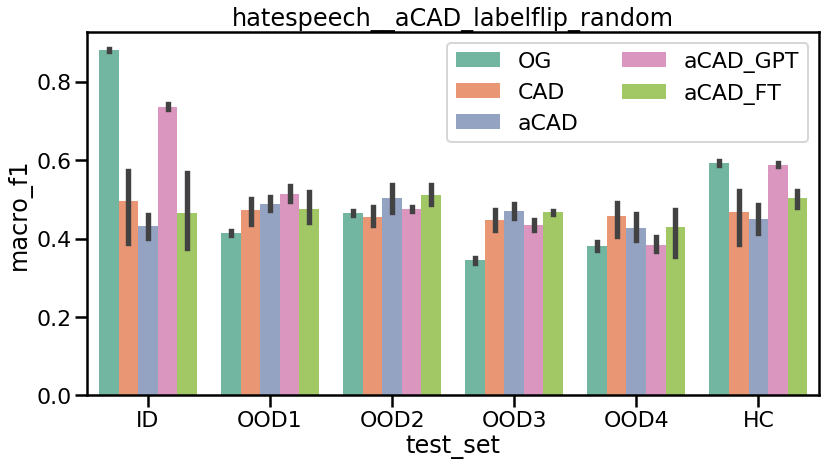

In [71]:
import seaborn as sns
import matplotlib as mpl 

sns.set_context('poster')

fig, ax = plt.subplots(figsize = (12, 7))
sns.barplot(data = all_results_df, x = 'test_set', y = 'macro_f1', #join = False,
             hue = 'mode', palette="Set2", # markers = True,#, hue_norm=mpl.colors.LogNorm()
            ax = ax)
title = construct + '_' + all_cad_onesided + flip_pj
ax.set_title(title)
plt.legend(ncol=2)
# plt.savefig('../results/figures/svm_%s.pdf' %title)
plt.tight_layout()
plt.show()

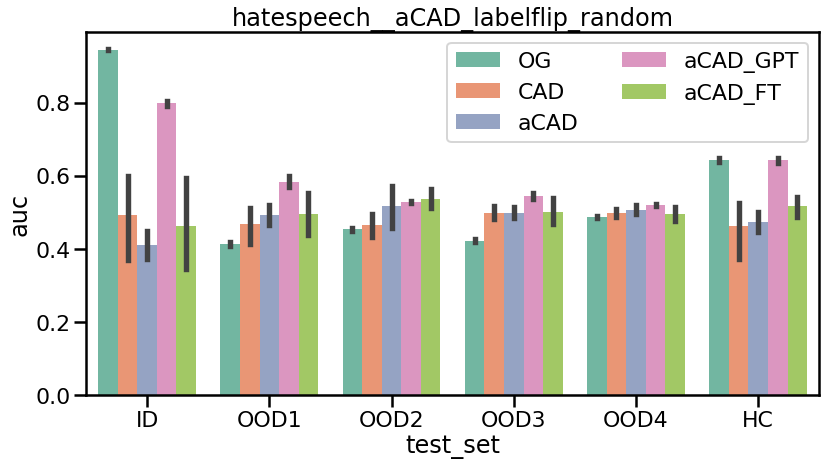

In [72]:
fig, ax = plt.subplots(figsize = (12, 7))
sns.barplot(data = all_results_df, x = 'test_set', y = 'auc', #join = False,
             hue = 'mode', palette="Set2", # markers = True,#, hue_norm=mpl.colors.LogNorm()
            ax = ax)
title = construct + '_' + all_cad_onesided + flip_pj
ax.set_title(title)
plt.legend(ncol=2)
# plt.savefig('../results/figures/svm_%s.pdf' %title)
plt.tight_layout()
plt.show()

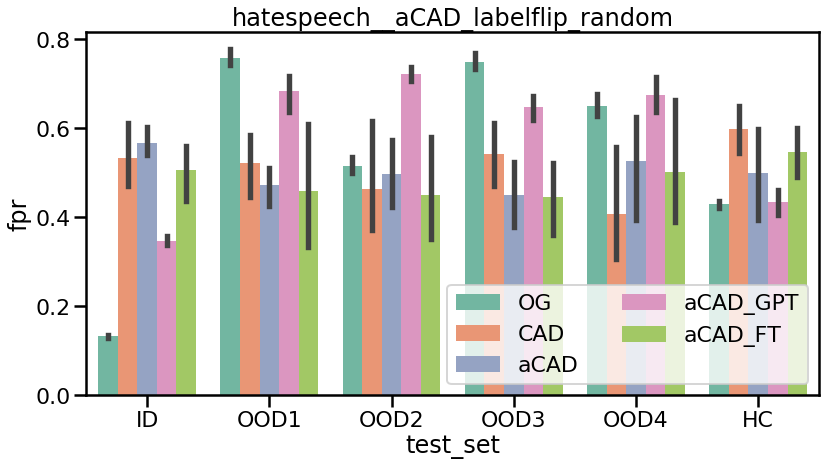

In [73]:
fig, ax = plt.subplots(figsize = (12, 7))
sns.barplot(data = all_results_df, x = 'test_set', y = 'fpr', #join = False,
             hue = 'mode', palette="Set2", # markers = True,#, hue_norm=mpl.colors.LogNorm()
            ax = ax)
title = construct + '_' + all_cad_onesided + flip_pj
ax.set_title(title)
plt.legend(ncol=2)
plt.savefig('../results/figures/svm_%s.pdf' %title)
plt.tight_layout()
plt.show()

In [74]:
### Takeaways